

# Evaluate spatial resolution with Point-Spread Functions (PSFs) and Cross-Talk Functions (CTFs)

Point-Spread Functions (PSFs) represent  a source estimation method's artifical spread or "leakage" from one point source (i.e. dipole at one vertex) to all other sources (e.g. across the whole cortical surface or brain volume). Cross-Talk Functions (CTFs) represent the spread from all sources to one particular point source. 

In short, PSFs show the spread "from" and CTFs "to" a source. Ideally, there should be no artificial spread or leakage, i.e. PSF and CTFs distributions should be zero everywhere except for the source of interest. In reality, PSFs and CTFs can be far from ideal, due to the "undeterdeminacy of the inverse problem", i.e. information about the spatial structure of brain sources is lost already in the measurement. This is another way of saying that EEG/MEG have limited spatial resolution. To complicate things, spatial resolution can vary depending on brain area (e.g. its distance to the sensors) and a range of other parameters, such as signal-to-noise ratio, measurement configuration (e.g. EEG vs MEG), source orientation, and source estimation method (and whether their assumptions are correct or not).

However, we have the tools to evaluate how good or bad the situation really is for a specific dataset. We can compute PSFs and CTFs for any location in the source space, by simulating point sources in each location and feeding their data through the source estimation pipeline. We can then visually inspect these distributions, or go further and quantify some of their features for an objective methods comparison. This will be demonstrated in the following notebook.

Note that these concepts apply only to linear methods such as L2-minimum-norm type methods and some beamformers. While they can also be used with some nonlinear methods (e.g. L1-norm), their interpretation is more complicated.


# We need forward and inverse operator

In order to compute PSFs and CTFs, we only need the forward solution (leadfield) and inverse operator. We do NOT need the data, since the PSFs and CTFs will be computed for simulated point sources. 

In [1]:
import numpy as np
import mne
from mne.datasets import sample
from mne.minimum_norm import (
    get_cross_talk,
    get_point_spread,
    make_inverse_resolution_matrix,
)
from mne_connectivity.viz import plot_connectivity_circle

print(__doc__)

data_path = sample.data_path()
subjects_dir = data_path / "subjects"
meg_path = data_path / "MEG" / "sample"
fname_fwd = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"
fname_cov = meg_path / "sample_audvis-cov.fif"
fname_evo = meg_path / "sample_audvis-ave.fif"

# read forward solution
forward = mne.read_forward_solution(fname_fwd)
# convert forward operator to fixed source orientations
mne.convert_forward_solution(forward, surf_ori=True, force_fixed=True, copy=False)

# noise covariance matrix, for inverse operator
noise_cov = mne.read_cov(fname_cov)

# evoked data, only for info
evoked = mne.read_evokeds(fname_evo, 0)

# make inverse operator from forward solution
# free source orientation
inverse_operator = mne.minimum_norm.make_inverse_operator(
    info=evoked.info, forward=forward, noise_cov=noise_cov, loose=0., depth=None
)


Automatically created module for IPython interactive environment
Reading forward solution from C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local 

We first compute the "resolution matrix", i.e. the inverse operator applied to the leadfield. The leadfield contains topographies for all point sources in our models, and therefore this step yields a matrix that contains PSFs as its columns and CTFs as its rows (don't worry about the details here).

The this resolution matrix is used to extract the relevant PSFs and CTFs.

In [2]:
# We need to specify the relevant parameters for source estimation
# regularisation parameter
snr = 3.0
lambda2 = 1.0 / snr**2
method='MNE'

# compute resolution matrix for sLORETA
rm = make_inverse_resolution_matrix(
    forward, inverse_operator, method=method, lambda2=lambda2
)

# get PSF and CTF for sLORETA at one vertex (here: left inferior temporal cortex)
# sources = [1000]
sources = [2000]

stc_psf = get_point_spread(rm, forward["src"], sources, norm=True)

stc_ctf = get_cross_talk(rm, forward["src"], sources, norm=True)

    364 out of 366 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Applying inverse operator to ""...
    Picked 364 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  43.2% variance
[done]
Dimension of Inverse Matrix: (7498, 364)
Dimensions of resolution matrix: 7498 by 7498.


## Visualize
PSF:



In [3]:
# Which vertex corresponds to selected source
vertno_lh = inverse_operator["src"][0]["vertno"]
verttrue = [vertno_lh[sources[0]]]  # just one vertex

# find vertices with maxima in PSF and CTF
vert_max_psf = vertno_lh[stc_psf.data.argmax()]
vert_max_ctf = vertno_lh[stc_ctf.data.argmax()]

maxval = np.abs(stc_psf.data).max()

brain_psf = stc_psf.plot("sample", "inflated", "lh", subjects_dir=subjects_dir, clim={'kind': 'value', 'lims': [0, maxval/2, maxval]})
brain_psf.show_view("ventral")
brain_psf.add_text(0.1, 0.9, method + " PSF", "title", font_size=16)

# True source location for PSF
brain_psf.add_foci(
    verttrue, coords_as_verts=True, scale_factor=1.0, hemi="lh", color="green"
)
# Maximum of PSF
brain_psf.add_foci(
    vert_max_psf, coords_as_verts=True, scale_factor=1.0, hemi="lh", color="black"
)

Using pyvistaqt 3d backend.
False


CTF:



In [4]:
maxval = np.abs(stc_ctf.data).max()

brain_ctf = stc_ctf.plot("sample", "inflated", "lh", subjects_dir=subjects_dir, clim={'kind': 'value', 'lims': [0, maxval/2, maxval]})
brain_ctf.add_text(0.1, 0.9, method + " CTF", "title", font_size=16)
brain_ctf.show_view("ventral")
brain_ctf.add_foci(
    verttrue, coords_as_verts=True, scale_factor=1.0, hemi="lh", color="green"
)
# Maximum of CTF
brain_ctf.add_foci(
    vert_max_ctf, coords_as_verts=True, scale_factor=1.0, hemi="lh", color="black"
)

False


Exercises:
* How does localization accuracy differ between methods (i.e. distance between black and green balls)?
* What is the difference between PSF and CTF? Does this change depending on the method you use?
* Try other vertices (randomly choose some). How does spatial resolution depend on source location?



# PSFs and CTFs for Regions-Of-Interest (ROIs, "Labels")

In [5]:
labels = mne.read_labels_from_annot("sample", parc="aparc", subjects_dir=subjects_dir)
n_labels = len(labels)
label_colors = [label.color for label in labels]
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith("lh")]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + "rh" for label in lh_labels]

Reading labels from parcellation...
   read 34 labels from C:\Users\olaf\mne_data\MNE-sample-data\subjects\sample\label\lh.aparc.annot
   read 34 labels from C:\Users\olaf\mne_data\MNE-sample-data\subjects\sample\label\rh.aparc.annot


We summarise the PSFs per label by their first five principal components, and use the first component to evaluate label-to-label leakage below.

In [6]:
# Compute first PCA component across PSFs within labels.
# Note the differences in explained variance, probably due to different
# spatial extents of labels.
n_comp = 5
stcs_psf, pca_vars = get_point_spread(
    rm, inverse_operator["src"], labels, mode="pca", n_comp=n_comp, norm=None, return_pca_vars=True
)
n_verts = rm.shape[0]


We can show the explained variances of principal components per label. Note how they differ across labels, most likely due to their varying spatial extent.

In [7]:
with np.printoptions(precision=1):
    for [name, var] in zip(label_names, pca_vars):
        print(f"{name}: {var.sum():.1f}% {var}")

bankssts-lh: 92.9% [41.3 31.1  8.8  6.6  5.1]
bankssts-rh: 92.4% [52.6 16.5 14.4  5.5  3.3]
caudalanteriorcingulate-lh: 97.5% [47.5 30.6 11.1  7.3  1. ]
caudalanteriorcingulate-rh: 95.4% [44.8 26.4 11.8  8.5  4. ]
caudalmiddlefrontal-lh: 84.7% [30.7 24.7 12.6  9.3  7.4]
caudalmiddlefrontal-rh: 81.5% [25.2 21.5 13.5 13.3  8.1]
cuneus-lh: 91.8% [38.9 26.8 15.   8.2  2.9]
cuneus-rh: 92.7% [39.8 27.1 13.9  7.7  4.2]
entorhinal-lh: 98.3% [54.6 33.7  6.4  2.5  1.2]
entorhinal-rh: 99.7% [48.3 41.7  6.6  2.7  0.3]
frontalpole-lh: 99.9% [71.8 22.1  3.4  2.2  0.5]
frontalpole-rh: 99.9% [70.7 24.1  2.6  1.8  0.6]
fusiform-lh: 82.3% [32.2 19.6 14.8  8.5  7.1]
fusiform-rh: 83.8% [30.3 22.7 14.1 10.5  6.2]
inferiorparietal-lh: 67.0% [18.6 15.8 12.3 10.2 10.1]
inferiorparietal-rh: 65.7% [16.6 14.9 12.5 11.5 10.2]
inferiortemporal-lh: 78.8% [22.8 17.2 17.  13.7  8.2]
inferiortemporal-rh: 83.2% [25.4 20.7 18.  10.4  8.8]
insula-lh: 86.6% [37.5 21.2 14.7  6.9  6.3]
insula-rh: 89.1% [41.4 21.4 14.5  6.4 

The output shows the summed variance explained by the first five principal components as well as the explained variances of the individual components.

Below we compute all-to-all pairwise leakage among 68 regions in source space based on MNE inverse solutions and a FreeSurfer cortical parcellation. Label-to-label leakage is estimated as the correlation among the labels' point-spread functions (PSFs). It is visualized using a circular graph which is ordered based on the locations of the regions in the axial plane.
Note that correlations ignore the overall amplitude of PSFs, i.e. they do not show which region will potentially be the bigger "leaker".

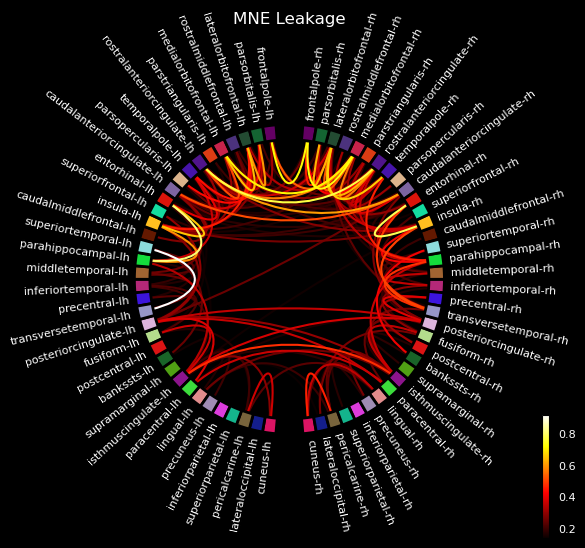

(<Figure size 800x800 with 2 Axes>,
 <PolarAxes: title={'center': 'MNE Leakage'}>)

In [8]:
from mne.viz import circular_layout
from matplotlib import pyplot as plt

# get PSFs from Source Estimate objects into matrix
psfs_mat = np.zeros([n_labels, n_verts])
# Leakage matrix for MNE, get first principal component per label
for [i, s] in enumerate(stcs_psf):
    psfs_mat[i, :] = s.data[:, 0]
# Compute label-to-label leakage as Pearson correlation of PSFs
# Sign of correlation is arbitrary, so take absolute values
leakage = np.abs(np.corrcoef(psfs_mat))

# Save the plot order and create a circular layout
node_order = lh_labels[::-1] + rh_labels  # mirror label order across hemis
node_angles = circular_layout(
    label_names, node_order, start_pos=90, group_boundaries=[0, len(label_names) / 2]
)
# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 200 strongest connections.
fig, ax = plt.subplots(
    figsize=(8, 8), facecolor="black", subplot_kw=dict(projection="polar")
)
plot_connectivity_circle(
    leakage,
    label_names,
    n_lines=200,
    node_angles=node_angles,
    node_colors=label_colors,
    title=method + " Leakage",
    ax=ax,
)

Exercises:
* Compare methods.
* Change SNR for regularization.

# Compare MEG and EEG+MEG with quantitative "resolution metrics"

In [9]:
# forward operator with fixed source orientations
forward_emeg = mne.convert_forward_solution(
    forward, surf_ori=True, force_fixed=True
)

# create a forward solution with MEG only
forward_meg = mne.pick_types_forward(forward, meg=True, eeg=False)

# make inverse operator from forward solution for MEG and EEGMEG
inv_emeg = mne.minimum_norm.make_inverse_operator(
    info=evoked.info, forward=forward, noise_cov=noise_cov, loose=0.0, depth=None
)

inv_meg = mne.minimum_norm.make_inverse_operator(
    info=evoked.info, forward=forward_meg, noise_cov=noise_cov, loose=0.0, depth=None
)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
    306 out of 366 channels remain after picking
Computing inverse operator with 364 channels.
    364 out of 366 channels remain after picking
Selected 364 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 4)
Computing rank from covariance with rank=None
    Using tolerance 3.3e-13 (2.2e-16 eps * 305 dim * 4.8  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 4.7e-14 (2.2e-16 eps * 59 dim * 3.6  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
C

Compute resolution matrices, localization error, and spatial deviations for combined EEG+MEG:

In [10]:
from mne.minimum_norm.spatial_resolution import resolution_metrics

rm_emeg = make_inverse_resolution_matrix(
    forward_emeg, inv_emeg, method="MNE", lambda2=lambda2
)
ple_psf_emeg = resolution_metrics(
    rm_emeg, inv_emeg["src"], function="psf", metric="peak_err"
)
sd_psf_emeg = resolution_metrics(
    rm_emeg, inv_emeg["src"], function="psf", metric="sd_ext"
)
del rm_emeg

    364 out of 366 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Applying inverse operator to ""...
    Picked 364 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  43.2% variance
[done]
Dimension of Inverse Matrix: (7498, 364)
Dimensions of resolution matrix: 7498 by 7498.


Do the same for MEG only:

In [11]:
rm_meg = make_inverse_resolution_matrix(
    forward_meg, inv_meg, method="MNE", lambda2=lambda2
)
ple_psf_meg = resolution_metrics(
    rm_meg, inv_meg["src"], function="psf", metric="peak_err"
)
sd_psf_meg = resolution_metrics(rm_meg, inv_meg["src"], function="psf", metric="sd_ext")
del rm_meg

    305 out of 306 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Applying inverse operator to ""...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  46.7% variance
[done]
Dimension of Inverse Matrix: (7498, 305)
Dimensions of resolution matrix: 7498 by 7498.


In [12]:
# Combined EEG/MEG
brain_ple_emeg = ple_psf_emeg.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=1,
    clim=dict(kind="value", lims=(0, 2, 4)),
)

brain_ple_emeg.add_text(0.1, 0.9, "PLE PSF EMEG", "title", font_size=16)

# MEG only
brain_ple_meg = ple_psf_meg.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=2,
    clim=dict(kind="value", lims=(0, 2, 4)),
)

brain_ple_meg.add_text(0.1, 0.9, "PLE PSF MEG", "title", font_size=16)

False
False


In order to compare distributions in one plot, we can compute and visualize their difference:

In [13]:
# difference of distributions "EEG+MEG minus MEG"
diff_ple = ple_psf_emeg - ple_psf_meg

brain_ple_diff = diff_ple.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=3,
    clim=dict(kind="value", pos_lims=(0.0, 0.5, 1.0)),
    smoothing_steps=20,
)

brain_ple_diff.add_text(0.1, 0.9, "PLE EMEG-MEG", "title", font_size=16)

False


Create similar plots for "spatial deviation", a metric for the spatial extent of distributions:

In [14]:
brain_sd_emeg = sd_psf_emeg.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=4,
    clim=dict(kind="value", lims=(0, 2, 4)),
)

brain_sd_emeg.add_text(0.1, 0.9, "SD PSF EMEG", "title", font_size=16)

brain_sd_meg = sd_psf_meg.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=5,
    clim=dict(kind="value", lims=(0, 2, 4)),
)

brain_sd_meg.add_text(0.1, 0.9, "SD PSF MEG", "title", font_size=16)

diff_sd = sd_psf_emeg - sd_psf_meg

brain_sd_diff = diff_sd.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=6,
    clim=dict(kind="value", pos_lims=(0.0, 0.5, 1.0)),
    smoothing_steps=20,
)

brain_sd_diff.add_text(0.1, 0.9, "SD EMEG-MEG", "title", font_size=16)

False
False
False


__Exercises:__
* Compute resolution metrics for CTFs instead of PSFs.
* Compare different methods.
* Try different SNRs for regularization.

# We can also compare spatial resolution among different methods in the same way

In [15]:
rm_mne = make_inverse_resolution_matrix(
    forward, inverse_operator, method="MNE", lambda2=lambda2
)
ple_mne_psf = resolution_metrics(
    rm_mne, inverse_operator["src"], function="psf", metric="peak_err"
)
sd_mne_psf = resolution_metrics(
    rm_mne, inverse_operator["src"], function="psf", metric="sd_ext"
)
del rm_mne

rm_dspm = make_inverse_resolution_matrix(
    forward, inverse_operator, method="dSPM", lambda2=lambda2
)
ple_dspm_psf = resolution_metrics(
    rm_dspm, inverse_operator["src"], function="psf", metric="peak_err"
)
sd_dspm_psf = resolution_metrics(
    rm_dspm, inverse_operator["src"], function="psf", metric="sd_ext"
)
del rm_dspm

# Differences
diff_ple = ple_mne_psf - ple_dspm_psf
diff_sd = sd_mne_psf - sd_dspm_psf


    364 out of 366 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
Applying inverse operator to ""...
    Picked 364 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  43.2% variance
[done]
Dimension of Inverse Matrix: (7498, 364)
Dimensions of resolution matrix: 7498 by 7498.
    364 out of 366 channels remain after picking
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 360 (4 small eigenvalues omitted)
    Computing nois

Plot the localisation error distributions:

In [16]:
brain_ple_mne = ple_mne_psf.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=1,
    clim=dict(kind="value", lims=(0, 2, 4)),
)
brain_ple_mne.add_text(0.1, 0.9, "PLE MNE", "title", font_size=16)

brain_ple_dspm = ple_dspm_psf.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=2,
    clim=dict(kind="value", lims=(0, 2, 4)),
)
brain_ple_dspm.add_text(0.1, 0.9, "PLE dSPM", "title", font_size=16)

brain_ple_diff = diff_ple.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=3,
    clim=dict(kind="value", pos_lims=(0.0, 1.0, 2.0)),
)
brain_ple_diff.add_text(0.1, 0.9, "PLE MNE-dSPM", "title", font_size=16)

False
False
False


Plot the spatial deviation distributions:

In [17]:
brain_sd_mne = sd_mne_psf.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=1,
    clim=dict(kind="value", lims=(0, 2, 4)),
)
brain_sd_mne.add_text(0.1, 0.9, "SD MNE", "title", font_size=16)

brain_sd_dspm = sd_dspm_psf.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=2,
    clim=dict(kind="value", lims=(0, 2, 4)),
)
brain_sd_dspm.add_text(0.1, 0.9, "SD dSPM", "title", font_size=16)

brain_sd_diff = diff_sd.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=3,
    clim=dict(kind="value", pos_lims=(0.0, 1.0, 2.0)),
)
brain_sd_diff.add_text(0.1, 0.9, "SD MNE-dSPM", "title", font_size=16)

False
False
False


These plots show that dSPM has generally higher spatial deviation than MNE (blue color), i.e. worse performance to distinguish different sources.

Exercises:
* Use other methods, e.g. sLORETA instead of dSPM
* Use CTFs instead of PSFs
* Change parameters as in previous exercises

PSFs and CTFs for beamformers

In [18]:
# We have to compute a data covariance matrix, hence create epochs from raw data
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"

# Read raw data
raw = mne.io.read_raw_fif(raw_fname)

# only pick good EEG/MEG sensors
raw.info["bads"] += ["EEG 053"]  # bads + 1 more
picks = mne.pick_types(raw.info, meg=True, eeg=True, exclude="bads")

# Find events
events = mne.find_events(raw)

# event_id = {'aud/l': 1, 'aud/r': 2, 'vis/l': 3, 'vis/r': 4}
event_id = {"vis/l": 1, "vis/r": 2}

tmin, tmax = -0.2, 0.25  # epoch duration
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    picks=picks,
    baseline=(-0.2, 0.0),
    preload=True,
)
del raw

# data covariance matrix for post-stimulus interval (around main evoked responses)
tmin, tmax = 0.05, 0.25
data_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=tmax, method="empirical")
info = epochs.info
del epochs

Opening raw data file C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
145 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 145 events and 69 original time points ...
0 bad epochs dropped
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 4495
[done]


In [19]:
# compute LCMV beamformer filters
filters = mne.beamformer.make_lcmv(
    info,
    forward,
    data_cov,
    reg=0.05,
    noise_cov=noise_cov,
    pick_ori=None,
    rank=None,
    weight_norm=None,
    reduce_rank=False,
    verbose=False,
)

In [20]:
# compute cross-talk functions (CTFs) for one target vertex
sources = [1000]  # 1000: "IT"; 3000: "insula"
verttrue = [forward["src"][0]["vertno"][sources[0]]]  # pick one vertex
rm_bf = mne.beamformer.make_lcmv_resolution_matrix(filters, forward, info)
stc = get_point_spread(rm_bf, forward["src"], sources, norm=True)
del rm_bf

    364 out of 366 channels remain after picking
Dimensions of LCMV resolution matrix: (7498, 7498).


In [21]:
# Which vertex corresponds to selected source
vertno_lh = forward["src"][0]["vertno"]
verttrue = [vertno_lh[sources[0]]]  # just one vertex

vert_max = vertno_lh[stc.data.argmax()]

brain = stc.plot(
    "sample",
    "inflated",
    "lh",
    subjects_dir=subjects_dir,
    figure=1,
    clim=dict(kind="value", lims=(0, 0.5, 1.)),
)
# mark true source location for CTFs
brain.add_foci(
    verttrue, coords_as_verts=True, scale_factor=1.0, hemi="lh", color="green"
)
# Maximum
brain.add_foci(
    vert_max, coords_as_verts=True, scale_factor=1.0, hemi="lh", color="black"
)

False


Once the resolution matrix has been computed, we can compute resolution metrics as above.

Exercises:
* Compute CTFs instead of PSFs.
* Compute resolution metrics and compare with minimum-norm type methods.
* Use beamformers with different data covariance matrices.